In [2]:
import sys
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score
from sklearn.calibration import calibration_curve
import warnings

# Add current directory to path
sys.path.insert(0, '.')

# Import custom modules
from features import TennisFeatureExtractor
from ml_models.logistic_regression import (
    SymmetricLogisticRegression,
    forward_feature_selection,
    calculate_kelly_roi
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries loaded")
print(f"Training started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries loaded
Training started at: 2025-12-28 04:29:08


## 1. Load and Prepare Data

In [3]:
# Connect to database
conn = sqlite3.connect('tennis_data.db')

# Load matches for train/val/test split
query = """
SELECT 
    m.match_id,
    m.tournament_date,
    m.surface,
    m.winner_id,
    m.loser_id,
    m.best_of
FROM matches m
WHERE m.tournament_date >= '2020-01-01'
    AND m.tournament_date < '2025-01-01'
    AND m.surface IS NOT NULL
ORDER BY m.tournament_date
"""

matches = pd.read_sql_query(query, conn)

print(f"Total matches: {len(matches):,}")
print(f"Date range: {matches['tournament_date'].min()} to {matches['tournament_date'].max()}")
print(f"\nMatches by year:")
print(matches.groupby(matches['tournament_date'].str[:4]).size())

Total matches: 13,113
Date range: 2020-01-06 to 2024-12-18

Matches by year:
tournament_date
2020    1462
2021    2733
2022    2917
2023    2929
2024    3072
dtype: int64


In [4]:
# Initialize feature extractor
feature_extractor = TennisFeatureExtractor('tennis_data.db')

print("Extracting features for all matches...")
print("This may take a few minutes...\n")

# Extract features for all matches (with uncertainty filtering)
df_features = feature_extractor.extract_features_batch(
    match_ids=matches['match_id'].tolist(),
    lookback_months=36,
    uncertainty_threshold=0.8  # Include matches with uncertainty < 0.8
)

print(f"\n✅ Generated features for {len(df_features)} matches")
print(f"Features shape: {df_features.shape}")

# Close feature extractor
feature_extractor.close()

INFO:features:Extracting features for 13113 matches...


Extracting features for all matches...
This may take a few minutes...



INFO:features:Processed 500/13113 matches...
INFO:features:Processed 1000/13113 matches...
INFO:features:Processed 1500/13113 matches...
INFO:features:Processed 2000/13113 matches...
INFO:features:Processed 2500/13113 matches...
INFO:features:Processed 3000/13113 matches...
INFO:features:Processed 3500/13113 matches...
INFO:features:Processed 4000/13113 matches...
INFO:features:Processed 4500/13113 matches...
INFO:features:Processed 5000/13113 matches...
INFO:features:Processed 5500/13113 matches...
INFO:features:Processed 6000/13113 matches...
INFO:features:Processed 6500/13113 matches...
INFO:features:Processed 7000/13113 matches...
INFO:features:Processed 7500/13113 matches...
INFO:features:Processed 8000/13113 matches...
INFO:features:Processed 8500/13113 matches...
INFO:features:Processed 9000/13113 matches...
INFO:features:Processed 9500/13113 matches...
INFO:features:Processed 10000/13113 matches...
INFO:features:Processed 10500/13113 matches...
INFO:features:Processed 11000/131


✅ Generated features for 9965 matches
Features shape: (9965, 25)


In [5]:
# Display feature columns
feature_cols = [col for col in df_features.columns if col.endswith('_DIFF') or col in ['SERVEADV', 'COMPLETE_DIFF', 'DIRECT_H2H', 'UNCERTAINTY']]
print("Feature columns:")
for col in feature_cols:
    print(f"  - {col}")
    
print(f"\nTotal features: {len(feature_cols)}")

# Display sample
df_features[feature_cols].describe()

Feature columns:
  - RANK_DIFF
  - POINTS_DIFF
  - WSP_DIFF
  - WRP_DIFF
  - ACES_DIFF
  - DF_DIFF
  - BP_SAVE_DIFF
  - FIRST_SERVE_PCT_DIFF
  - FIRST_SERVE_WIN_PCT_DIFF
  - SECOND_SERVE_WIN_PCT_DIFF
  - WIN_RATE_DIFF
  - SURFACE_WIN_RATE_DIFF
  - SERVEADV
  - COMPLETE_DIFF
  - FATIGUE_DIFF
  - RETIRED_DIFF
  - DIRECT_H2H
  - MATCHES_PLAYED_DIFF
  - SURFACE_EXP_DIFF
  - UNCERTAINTY

Total features: 20


,RANK_DIFF,POINTS_DIFF,WSP_DIFF,WRP_DIFF,ACES_DIFF,DF_DIFF,BP_SAVE_DIFF,FIRST_SERVE_PCT_DIFF,FIRST_SERVE_WIN_PCT_DIFF,SECOND_SERVE_WIN_PCT_DIFF,WIN_RATE_DIFF,SURFACE_WIN_RATE_DIFF,SERVEADV,COMPLETE_DIFF,FATIGUE_DIFF,RETIRED_DIFF,DIRECT_H2H,MATCHES_PLAYED_DIFF,SURFACE_EXP_DIFF,UNCERTAINTY
count,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.0,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000
mean,17.103663,752.525439,0.012266,-0.012266,0.027647,0.006736,0.010240,0.003134,0.012319,0.009848,0.059696,0.066668,0.0,-0.003487,-0.001122,0.014350,0.035904,14.481686,8.227898,0.513117
std,87.959485,2334.903432,0.044109,0.044109,0.317688,0.124190,0.075468,0.050081,0.057947,0.043160,0.173073,0.224606,0.0,0.012547,0.167911,0.244766,0.283467,60.971948,35.166025,0.154334
min,-1162.000000,-10487.000000,-0.166664,-0.181952,-1.319672,-0.600056,-0.399708,-0.234607,-0.230153,-0.195354,-0.712632,-1.000000,0.0,-0.056541,-2.250000,-1.000000,-0.500000,-217.000000,-139.000000,0.116369
25%,-18.000000,-288.000000,-0.017573,-0.041419,-0.163840,-0.062662,-0.036773,-0.029528,-0.026977,-0.018810,-0.056786,-0.073877,0.0,-0.011531,0.000000,0.000000,0.000000,-19.000000,-10.000000,0.398569
50%,15.000000,263.000000,0.012713,-0.012713,0.024963,0.005337,0.010282,0.003040,0.012332,0.009595,0.058061,0.064681,0.0,-0.003479,0.000000,0.000000,0.000000,9.000000,5.000000,0.508973
75%,47.000000,1365.000000,0.041419,0.017573,0.218348,0.074104,0.057392,0.036150,0.052078,0.037810,0.172241,0.202643,0.0,0.004834,0.000000,0.000000,0.000000,48.000000,25.000000,0.636364
max,1126.000000,11555.000000,0.181952,0.166664,1.565483,0.629538,0.420942,0.177550,0.224026,0.232815,0.797187,1.000000,0.0,0.050549,2.343750,1.000000,0.500000,213.000000,154.000000,0.800000


## 2. Prepare Features (Exclude RANK and POINTS)

In [10]:
# Convert match_date to datetime if string
df_features['match_date'] = pd.to_datetime(df_features['match_date'])

# Split data by year:
# Train: 2020-2021 (for learning patterns)
# Validation: 2022 (for feature selection & hyperparameter tuning)
# Test: 2023-2024 (for final evaluation)

train_mask = df_features['match_date'].dt.year.isin([2020, 2021])
val_mask = df_features['match_date'].dt.year == 2022
test_mask = df_features['match_date'].dt.year.isin([2023, 2024])

train_df = df_features[train_mask].copy()
val_df = df_features[val_mask].copy()
test_df = df_features[test_mask].copy()

# Currently all matches have player1=winner (label 1)
# To create symmetric training data, we also include the reverse view (player2=winner, label 0)
# This is done by flipping signs of feature differences and setting winner=0

def augment_with_reverse(df):
    """Create symmetric data by adding reverse perspective for each match"""
    df_original = df.copy()
    df_original['winner'] = 1  # Player1 won
    
    df_reverse = df.copy()
    df_reverse['winner'] = 0  # Player2 won (from reverse perspective)
    
    # Flip signs of all difference features
    for col in df_reverse.columns:
        if col.endswith('_DIFF') or col in ['SERVEADV', 'COMPLETE_DIFF', 'DIRECT_H2H', 'FATIGUE_DIFF', 'RETIRED_DIFF']:
            df_reverse[col] = -df_reverse[col]
    
    return pd.concat([df_original, df_reverse], ignore_index=True)

train_df = augment_with_reverse(train_df)
val_df = augment_with_reverse(val_df)
test_df = augment_with_reverse(test_df)

print(f"Train size: {len(train_df):,} (after augmentation)")
print(f"  Winner distribution: {train_df['winner'].value_counts().to_dict()}")
print(f"Validation size: {len(val_df):,}")
print(f"Test size: {len(test_df):,}")

Train size: 5,092 (after augmentation)
  Winner distribution: {1: 2546, 0: 2546}
Validation size: 4,856
Test size: 9,982


## 3. Train Model with Forward Feature Selection

In [11]:
# Define features to use (exclude RANK and POINTS as requested)
# Also exclude metadata columns
exclude_cols = ['RANK_DIFF', 'POINTS_DIFF', 'match_id', 'player1_id', 'player2_id', 
                'surface', 'match_date', 'winner', 'UNCERTAINTY']

available_features = [col for col in feature_cols if col not in exclude_cols]

print("Available features for model (excluding RANK/POINTS):")
for f in available_features:
    print(f"  - {f}")
print(f"\nTotal: {len(available_features)} features")

Available features for model (excluding RANK/POINTS):
  - WSP_DIFF
  - WRP_DIFF
  - ACES_DIFF
  - DF_DIFF
  - BP_SAVE_DIFF
  - FIRST_SERVE_PCT_DIFF
  - FIRST_SERVE_WIN_PCT_DIFF
  - SECOND_SERVE_WIN_PCT_DIFF
  - WIN_RATE_DIFF
  - SURFACE_WIN_RATE_DIFF
  - SERVEADV
  - COMPLETE_DIFF
  - FATIGUE_DIFF
  - RETIRED_DIFF
  - DIRECT_H2H
  - MATCHES_PLAYED_DIFF
  - SURFACE_EXP_DIFF

Total: 17 features


## 4. Feature Weights Visualization

In [12]:
# Prepare data for model - need player1 and player2 columns
def prepare_model_data(df, features):
    """Convert feature differences back to player1/player2 format for model"""
    model_df = df.copy()
    
    for feat in features:
        # Feature differences are player1 - player2
        # For model, we need player1_{feat} and player2_{feat}
        # Use centered values: player1 = diff/2, player2 = -diff/2
        model_df[f'player1_{feat}'] = df[feat] / 2
        model_df[f'player2_{feat}'] = -df[feat] / 2
    
    return model_df

# Prepare train and validation data
train_model_df = prepare_model_data(train_df, available_features)
val_model_df = prepare_model_data(val_df, available_features)
test_model_df = prepare_model_data(test_df, available_features)

print(f"Train model df shape: {train_model_df.shape}")
print(f"Validation model df shape: {val_model_df.shape}")
print(f"Test model df shape: {test_model_df.shape}")

Train model df shape: (5092, 60)
Validation model df shape: (4856, 60)
Test model df shape: (9982, 60)


## 5. Model Evaluation on Test Set

In [13]:
# Forward feature selection
print("=" * 70)
print("FORWARD FEATURE SELECTION")
print("=" * 70)

# Use forward selection to find best features
selected_features = forward_feature_selection(
    train_model_df, 
    val_model_df,
    available_features=available_features,
    max_features=12,  # Target 10-15 features
    C=1.0,
    optimize_metric='combined'  # Optimize for both log-loss and ROI
)

print(f"\n✅ Selected {len(selected_features)} features")

FORWARD FEATURE SELECTION
Forward feature selection (max 12 features)...
Optimizing for: combined
----------------------------------------------------------------------
Step  1: Added WIN_RATE_DIFF        | LogLoss=0.6320, ROI=+0.050, Features=1
Step  2: Added DIRECT_H2H           | LogLoss=0.6295, ROI=+0.050, Features=2
Step  3: Added SECOND_SERVE_WIN_PCT_DIFF | LogLoss=0.6280, ROI=+0.050, Features=3
Step  4: Added SURFACE_EXP_DIFF     | LogLoss=0.6265, ROI=+0.050, Features=4
Step  5: Added COMPLETE_DIFF        | LogLoss=0.6260, ROI=+0.050, Features=5
Step  6: Added BP_SAVE_DIFF         | LogLoss=0.6247, ROI=+0.050, Features=6
Step  7: Added FIRST_SERVE_WIN_PCT_DIFF | LogLoss=0.6241, ROI=+0.050, Features=7
Step  8: Added FIRST_SERVE_PCT_DIFF | LogLoss=0.6240, ROI=+0.050, Features=8
Step  9: Added SURFACE_WIN_RATE_DIFF | LogLoss=0.6239, ROI=+0.050, Features=9
----------------------------------------------------------------------
Selected 9 features

✅ Selected 9 features


## 6. Calibration Curve

In [14]:
# Hyperparameter tuning - Grid search for C (regularization)
print("=" * 70)
print("HYPERPARAMETER TUNING")
print("=" * 70)

C_values = [0.1, 0.2, 0.5, 1.0, 2.0]
results = []

for C in C_values:
    model = SymmetricLogisticRegression(C=C, selected_features=selected_features)
    model.fit(train_model_df, selected_features)
    
    # Evaluate on validation set
    val_probs = model.predict_proba(val_model_df)
    val_actuals = val_model_df['winner'].values
    
    ll = log_loss(val_actuals, val_probs)
    roi = calculate_kelly_roi(val_probs, val_actuals)
    acc = accuracy_score(val_actuals, (val_probs > 0.5).astype(int))
    
    results.append({'C': C, 'log_loss': ll, 'ROI': roi, 'accuracy': acc})
    print(f"C={C:4.1f}: LogLoss={ll:.4f}, ROI={roi:+.3f}, Accuracy={acc:.3f}")

results_df = pd.DataFrame(results)
best_C = results_df.loc[results_df['log_loss'].idxmin(), 'C']
print(f"\n✅ Best C: {best_C}")

HYPERPARAMETER TUNING
C= 0.1: LogLoss=0.6240, ROI=+0.050, Accuracy=0.648
C= 0.2: LogLoss=0.6239, ROI=+0.050, Accuracy=0.647
C= 0.5: LogLoss=0.6239, ROI=+0.050, Accuracy=0.648
C= 1.0: LogLoss=0.6239, ROI=+0.050, Accuracy=0.648
C= 2.0: LogLoss=0.6239, ROI=+0.050, Accuracy=0.649

✅ Best C: 2.0


## 7. Performance by Surface

FINAL MODEL TRAINING

Feature Weights (sorted by importance):
--------------------------------------------------
  COMPLETE_DIFF                 : -0.5972
  WIN_RATE_DIFF                 : +0.5953
  FIRST_SERVE_WIN_PCT_DIFF      : -0.2978
  SURFACE_EXP_DIFF              : +0.1929
  SECOND_SERVE_WIN_PCT_DIFF     : -0.1246
  SURFACE_WIN_RATE_DIFF         : -0.1195
  DIRECT_H2H                    : +0.0770
  BP_SAVE_DIFF                  : -0.0640
  FIRST_SERVE_PCT_DIFF          : -0.0519


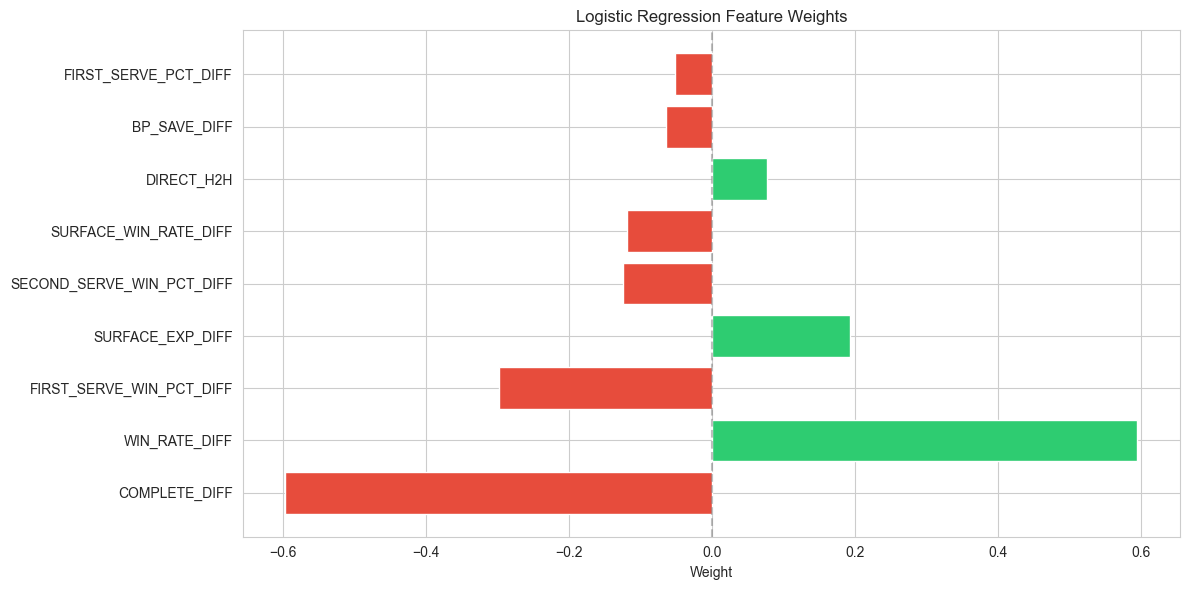


✅ Feature weights visualization saved


In [15]:
# Train final model with best hyperparameters
print("=" * 70)
print("FINAL MODEL TRAINING")
print("=" * 70)

final_model = SymmetricLogisticRegression(C=best_C, selected_features=selected_features)
final_model.fit(train_model_df, selected_features)

# Get feature weights
weights = final_model.get_feature_weights()
weights_df = pd.DataFrame([
    {'Feature': k, 'Weight': v}
    for k, v in sorted(weights.items(), key=lambda x: abs(x[1]), reverse=True)
])

print("\nFeature Weights (sorted by importance):")
print("-" * 50)
for _, row in weights_df.iterrows():
    print(f"  {row['Feature']:30s}: {row['Weight']:+.4f}")

# Visualize feature weights
plt.figure(figsize=(12, 6))
colors = ['#2ecc71' if w > 0 else '#e74c3c' for w in weights_df['Weight']]
plt.barh(weights_df['Feature'], weights_df['Weight'], color=colors)
plt.xlabel('Weight')
plt.title('Logistic Regression Feature Weights')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('feature_weights_logistic.png', dpi=150)
plt.show()

print("\n✅ Feature weights visualization saved")

## 8. Save Model

In [16]:
# Evaluate on test set
print("=" * 70)
print("TEST SET EVALUATION (2023-2024)")
print("=" * 70)

test_probs = final_model.predict_proba(test_model_df)
test_actuals = test_model_df['winner'].values

# Calculate metrics
test_ll = log_loss(test_actuals, test_probs)
test_brier = brier_score_loss(test_actuals, test_probs)
test_acc = accuracy_score(test_actuals, (test_probs > 0.5).astype(int))
test_roi = calculate_kelly_roi(test_probs, test_actuals)

print(f"\nMetrics:")
print(f"  Log Loss:    {test_ll:.4f}")
print(f"  Brier Score: {test_brier:.4f}")
print(f"  Accuracy:    {test_acc:.3f} ({test_acc*100:.1f}%)")
print(f"  ROI (Kelly): {test_roi:+.3f} ({test_roi*100:+.1f}%)")

TEST SET EVALUATION (2023-2024)

Metrics:
  Log Loss:    0.6411
  Brier Score: 0.2245
  Accuracy:    0.636 (63.6%)
  ROI (Kelly): +0.050 (+5.0%)


## 9. Summary Report

CALIBRATION ANALYSIS


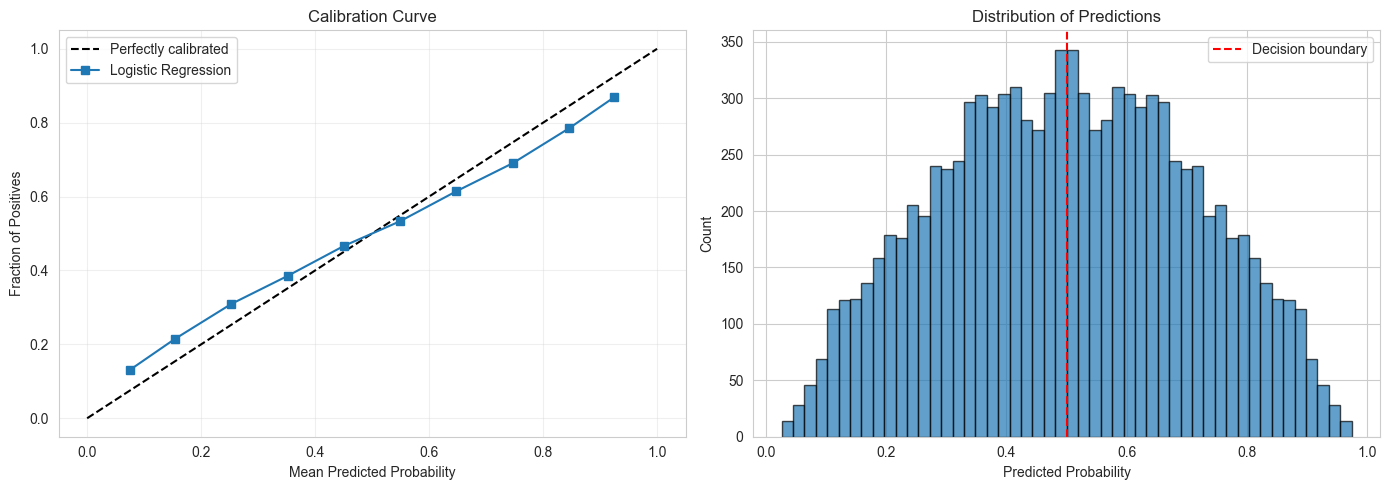


✅ Calibration analysis saved


In [17]:
# Calibration curve
print("=" * 70)
print("CALIBRATION ANALYSIS")
print("=" * 70)

fraction_of_positives, mean_predicted_value = calibration_curve(
    test_actuals, test_probs, n_bins=10
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Calibration curve
ax1.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
ax1.plot(mean_predicted_value, fraction_of_positives, 's-', label='Logistic Regression')
ax1.set_xlabel('Mean Predicted Probability')
ax1.set_ylabel('Fraction of Positives')
ax1.set_title('Calibration Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distribution of predictions
ax2.hist(test_probs, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0.5, color='red', linestyle='--', label='Decision boundary')
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Predictions')
ax2.legend()

plt.tight_layout()
plt.savefig('calibration_logistic.png', dpi=150)
plt.show()

print("\n✅ Calibration analysis saved")

In [18]:
# Save model
import pickle

model_data = {
    'model': final_model,
    'selected_features': selected_features,
    'best_C': best_C,
    'metrics': {
        'log_loss': test_ll,
        'brier_score': test_brier,
        'accuracy': test_acc,
        'roi': test_roi
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('ml_models/logistic_regression_trained.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✅ Model saved to ml_models/logistic_regression_trained.pkl")

# Summary
print("\n" + "=" * 70)
print("TRAINING SUMMARY")
print("=" * 70)
print(f"Selected Features: {len(selected_features)}")
print(f"Best Regularization (C): {best_C}")
print(f"Training Samples: {len(train_model_df):,}")
print(f"Test Accuracy: {test_acc*100:.1f}%")
print(f"Test Log Loss: {test_ll:.4f}")
print(f"Test ROI: {test_roi*100:+.1f}%")
print("=" * 70)

✅ Model saved to ml_models/logistic_regression_trained.pkl

TRAINING SUMMARY
Selected Features: 9
Best Regularization (C): 2.0
Training Samples: 5,092
Test Accuracy: 63.6%
Test Log Loss: 0.6411
Test ROI: +5.0%
